# **Lung Cancer Detection**

## Data Story

It was a project about chest cancer detection using machine learning and deep learning (Resnet 101V2) .

we classify and diagnose if the patient have cancer or not using AI model .

## Data Preparation

Images are not in dcm format, the images are in jpg or png to fit the model.

**Data contain:**
* 3 chest cancer types which are Adenocarcinoma,Large cell carcinoma, Squamous cell carcinoma 
* 1 folder for the normal cell

Data folder is the main folder that contain all the step folders
inside Data folder are test , train , valid.

### Importing Libraries

In [1]:
# import dataset from google drive
from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
import os
import cv2
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [3]:
#path to dataset
dir_path = '/content/drive/MyDrive/CTLungCancer/Data'
train_path = '/content/drive/MyDrive/CTLungCancer/Data/train'
test_path = '/content/drive/MyDrive/CTLungCancer/Data/test'
val_path = '/content/drive/MyDrive/CTLungCancer/Data/valid'

In [4]:
def GetDatasetSize(path):
    num_of_image = {}
    for folder in os.listdir(path):
        # Counting the Number of Files in the Folder
        num_of_image[folder] = len(os.listdir(os.path.join(path, folder)));
    return num_of_image;
    
train_set = GetDatasetSize(train_path)
val_set = GetDatasetSize(val_path)
test_set = GetDatasetSize(test_path)
print(train_set,"\n\n",val_set,"\n\n",test_set)

{'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa': 166, 'normal': 156, 'adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib': 315, 'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa': 245} 

 {'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa': 15, 'adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib': 23, 'normal': 13, 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa': 21} 

 {'adenocarcinoma': 143, 'large.cell.carcinoma': 72, 'squamous.cell.carcinoma': 105, 'normal': 67}


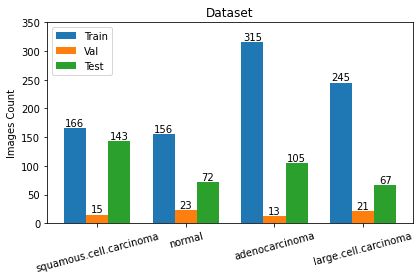

In [5]:
labels = ['squamous.cell.carcinoma', 'normal', 'adenocarcinoma', 'large.cell.carcinoma']
train_list = list(train_set.values())
val_list = list(val_set.values())
test_list = list(test_set.values())

x = np.arange(len(labels))  # the label locations
width = 0.25
  
# plot data in grouped manner of bar type
fig, ax = plt.subplots()
ax.bar(x-width, train_list, width,label='Train')
ax.bar(x, val_list, width,label='Val')
ax.bar(x+width, test_list, width,label='Test')

ax.legend()
leg = ax.legend(loc='upper left')
ax.set_ylabel('Images Count')
ax.set_title('Dataset')
plt.ylim([0,350])
plt.xticks(x, labels)
plt.xticks(rotation=15)


# plot text above label
# for tain
for i in range(len(labels)):
  ax.text(i-width,train_list[i],train_list[i],ha='center',va='bottom')

# for valid
for i in range(len(labels)):
  ax.text(i,val_list[i],val_list[i],ha='center',va='bottom')


# for test
for i in range(len(labels)):
  ax.text(i+width,test_list[i],test_list[i],ha='center',va='bottom')


fig.tight_layout()

plt.show()

## Importing Keras for Image Classification

In [6]:
import os
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPool2D, Conv2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers
from tensorflow.keras import Model

## Data Augmentation

In [7]:
# Data Augmentation
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split = 0.2,
                                  
        rotation_range=5,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.1,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest')

valid_datagen = ImageDataGenerator(rescale = 1./255,
                                  validation_split = 0.2)

test_datagen  = ImageDataGenerator(rescale = 1./255
                                  )

## Load Dataset

In [8]:

train_dataset  = train_datagen.flow_from_directory(directory = '/content/drive/MyDrive/CTLungCancer/Data/train',
                                                   target_size = (224,224),
                                                   class_mode = 'categorical',
                                                   batch_size = 32)

valid_dataset = valid_datagen.flow_from_directory(directory =  '/content/drive/MyDrive/CTLungCancer/Data/valid',
                                                  target_size = (224,224),
                                                  class_mode = 'categorical',
                                                  batch_size = 32)

test_dataset = test_datagen.flow_from_directory(directory ='/content/drive/MyDrive/CTLungCancer/Data/test',
                                                  target_size = (224,224),
                                                  class_mode = 'categorical',
                                                  batch_size = 32)


Found 882 images belonging to 4 classes.
Found 72 images belonging to 4 classes.
Found 387 images belonging to 4 classes.


## Resnet 101V2

In [9]:
base_model_2 = tf.keras.applications.ResNet101V2(input_shape=(224,224,3),include_top=False,weights="imagenet")
# Freezing Layers
for layer in base_model_2.layers:
    layer.trainable = False

171327488/171317808 [==============================] - 1s 0us/step


## Add FC Layers

In [10]:
x = base_model_2.output
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu')(x)
x = tf.keras.layers.MaxPool2D(pool_size=(2,2))(x)
x = tf.keras.layers.Conv2D(filters=32,padding='same', kernel_size=(3,3), activation='relu')(x) #return to 32
x = tf.keras.layers.MaxPool2D(pool_size=(2,2))(x)
x = tf.keras.layers.Conv2D(filters=64,padding='same', kernel_size=(3,3), activation='relu')(x)
x = tf.keras.layers.MaxPool2D(pool_size=(2,2),padding='same')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(1024, activation = 'relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(4, activation = "softmax")(x)
model = Model(inputs= base_model_2.input , outputs = x)

In [11]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [12]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image
plot_model(model, to_file='convnet.png', show_shapes=True,show_layer_names=True)
Image(filename='convnet.png')

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.775789 to fit



In [13]:

METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc')
]
model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=METRICS)

In [14]:
history=model.fit(train_dataset,validation_data=test_dataset,epochs =100,verbose = 1)

Epoch 1/100
28/28 [==============================] - 471s 16s/step - loss: 1.1504 - accuracy: 0.7681 - precision: 0.6212 - recall: 0.1859 - auc: 0.7352 - val_loss: 0.9374 - val_accuracy: 0.7965 - val_precision: 0.6324 - val_recall: 0.4444 - val_auc: 0.8359
Epoch 2/100
28/28 [==============================] - 19s 685ms/step - loss: 0.9501 - accuracy: 0.7866 - precision: 0.6201 - recall: 0.3776 - auc: 0.8263 - val_loss: 0.8264 - val_accuracy: 0.8094 - val_precision: 0.6575 - val_recall: 0.4961 - val_auc: 0.8680
Epoch 3/100
28/28 [==============================] - 19s 699ms/step - loss: 0.8639 - accuracy: 0.8194 - precision: 0.7342 - recall: 0.4354 - auc: 0.8565 - val_loss: 0.7576 - val_accuracy: 0.8269 - val_precision: 0.7045 - val_recall: 0.5297 - val_auc: 0.8928
Epoch 4/100
28/28 [==============================] - 19s 687ms/step - loss: 0.7390 - accuracy: 0.8554 - precision: 0.7853 - recall: 0.5805 - auc: 0.9048 - val_loss: 0.7807 - val_accuracy: 0.8495 - val_precision: 0.7188 - val_re

## Evaluate The Model

In [15]:
# Checking the Accuracy of the Model 
accuracy_resnet = model.evaluate_generator(generator= test_dataset)[1] 
print(f"The accuracy of the model RESNET 101V2 is = {accuracy_resnet*100} %")

The accuracy of the model RESNET 101V2 is = 98.51421117782593 %


## Results

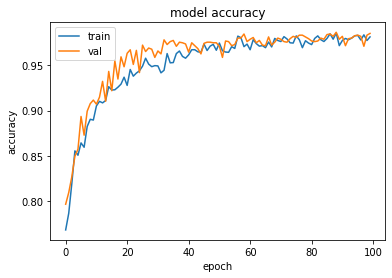

In [16]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
# plt.ylim([0.95,1])
plt.legend(['train', 'val'], loc='upper left')
plt.savefig("resnet_accuracy98.png")
plt.show()

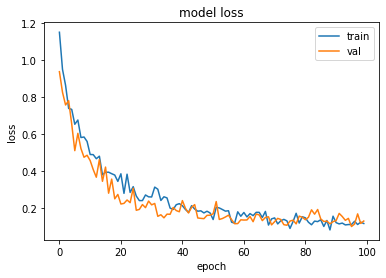

In [17]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
# plt.ylim([0.05,0.3])
plt.legend(['train', 'val'], loc='upper right')
plt.savefig("resnet_loss.png")
plt.show()

## Save Model

In [18]:
model.save('saved_resnet9805.h5')

In [20]:
# load model
load_model = tf.keras.models.load_model('/content/saved_resnet9805.h5')

## Prediction

In [24]:
from tensorflow.keras.preprocessing import image
def chestScanPrediction(path):
    classes_dir = ["Adenocarcinoma","Large cell carcinoma","Normal","Squamous cell carcinoma"]
    # Loading Image
    img = image.load_img(path, target_size=(224,224))
    # Normalizing Image
    norm_img = image.img_to_array(img)/255
    # Converting Image to Numpy Array
    input_arr_img = np.array([norm_img])
    # Getting Predictions
    pred = np.argmax(load_model.predict(input_arr_img))
    # Printing Model Prediction
    print(classes_dir[pred])

In [25]:
path = '/content/drive/MyDrive/CTLungCancer/Data/valid/large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa/000108.png'
chestScanPrediction(path)

Large cell carcinoma
